<a href="https://colab.research.google.com/github/ParichayMago/ZeroGrad/blob/master/MNIST_from_bytes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import math
# from torchvision.datasets import MNIST

In [2]:
# mnist_data = MNIST(root='data', download=True)
# mnist_data

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.02MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [3]:
data_path = "./data/MNIST/raw/"
file_n = ["t10k-images-idx3-ubyte","t10k-labels-idx1-ubyte","train-images-idx3-ubyte","train-labels-idx1-ubyte"]
file_n

['t10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [4]:
# train path
x_train_r = data_path + file_n[2]

with open(x_train_r, "rb") as f:
  f_bytes = f.read()
x_bytes = f_bytes[16:]

# normalizing here
x_norm = [i/255 for i in x_bytes]


# train label path
labels_p = data_path + file_n[3]

with open(labels_p, "rb") as fl:
    l_bytes = fl.read()
labels = l_bytes[8:]


In [11]:
x_test_r = data_path + file_n[0] # test tensor path
y_test_r = data_path + file_n[1] # test label path
y_test_r, x_test_r

('./data/MNIST/raw/t10k-labels-idx1-ubyte',
 './data/MNIST/raw/t10k-images-idx3-ubyte')

In [6]:
# test tensors
with open(x_test_r, "rb") as f:
  x_test_b = f.read()

x_test_= x_test_b[16:]
x_test = [i/255 for i in x_test_]

# test labels
with open(y_test_r, "rb") as f:
  y_test_b = f.read()

y_test = y_test_b[8:]

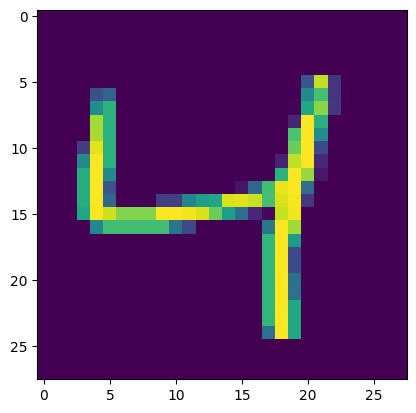

In [ ]:

img_10 = [[list(x_norm[(i*28)+(j*784):(i*28)+(j*784)+28]) for i in range(28)] for j in range(10)]
plt.imshow(img_10[2]);

In [7]:
import math
import random

class Neuron:
    def __init__(self, nin, final):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))
        self.final = final

    def __call__(self, inpts):
        out = sum([weight * inpt for weight, inpt in zip(self.weights, inpts)], self.bias)
        if not self.final:
            out = out.tanh()
        return out

    def parameters(self):
        out = self.weights + [self.bias]
        return out

class Layer:
    def __init__(self, nin, nout, final):
        self.neurons = [Neuron(nin, final) for _ in range(nout)]

    def __call__(self, inpt):
        out = [neuron(inpt) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        out = [p for neuron in self.neurons for p in neuron.parameters()]
        return out

class NLP:
    def __init__(self, nin, layers):
        layers_i = [nin] + layers
        self.layers = [Layer(layers_i[i], layers_i[i+1], False) if i != len(layers)-1 else Layer(layers_i[i], layers_i[i+1], True) for i in range(len(layers))]

    def __call__(self, inpts):
        x = inpts
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        out = [p for layer in self.layers for p in layer.parameters()]
        return out

In [8]:
import math

class Value:
    def __init__(self, data, _children=(), op=""):
        self.data = data
        self._prev = _children
        self.op = op
        self.grad = 0
        self._backward = lambda: None

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self,other), "+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (other * -1)

    def __truediv__(self, other):
        return self * (other**-1.0)

    def __repr__(self):
        return f"Data([{self.data}])"

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self+other

    def __rtruediv__(self, other):
        return self / other

    def __pow__(self, other):
        assert isinstance(other, float), "Only float valeus are allowed for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad +=  (other * (self.data**(other-1))) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        result = math.exp(self.data)
        out = Value(result, (self,), "exp")

        def _backward():
            self.grad += result * out.grad

        out._backward = _backward

        return out

    def log(self):
        result =  math.log(self.data)
        out = Value(result, (self,), "log")

        def _backward():
            self.grad += (self.data**-1.0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        e = math.exp((2 * self.data))
        result = (e-1)/(e+1)
        out = Value(result, (self,), "tanh")

        def _backward():
           self.grad += (1-(result**2)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        result = max(self.data, 0)
        out = Value(result, (self,), "relu")
        def _backward():
            if(self.data>0):
                self.grad += 1.0 *out.grad
            else:
                self.grad += 0
            # self.grad += 1.0 if self.data>0.1 else 0 * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [ ]:
fiv_tensor = [x_norm[i*784:(i+1)*784] for i in range(500) if labels[i] < 5]
fiv_label = [labels[i] for i in range(500) if labels[i] < 5]

fiv_tensor_test = [x_test[i*784:(i+1)*784] for i in range(50) if y_test[i] < 5]
fiv_label_test =  [y_test[i] for i in range(50) if y_test[i] < 5]

In [ ]:
nn_five = NLP(784, [32, 5])
t_loss = []

In [ ]:
for iter in range(5):
    total_train_loss = 0

    for start in range(int(len(fiv_tensor)//10)):
      # forward prop
        preds_batch = [nn_five(tensor) for tensor in fiv_tensor[start*10:10+(start*10)]]

        # softmaxing
        sft_preds_batch = []
        for preds in preds_batch:
            exp = [i.exp() for i in preds]
            sexp = sum(exp)
            sft_preds = [ex/sexp for ex in exp]
            sft_preds_batch.append(sft_preds)

        preds_vals = [sft_preds[lab] for sft_preds, lab in zip(sft_preds_batch, fiv_label[start*10:(start*10)+10])]
        loss = sum([p_val.log() * -1 for p_val in preds_vals])
        total_train_loss += loss.data

        # grad-decent
        for p in nn_five.parameters():
            p.grad = 0

        loss.backward()

        for p in nn_five.parameters():
            p.data = p.data - (0.001 * p.grad)

        print(f"iter: {iter}, batch:{start}, loss: {loss.data}")

    # validation testing
    val_preds = [nn_five(test_tensor) for test_tensor in fiv_tensor_test]

    val_sft_preds = []
    for preds in val_preds:
        exp = [i.exp() for i in preds]
        sexp = sum(exp)
        sft_preds = [ex/sexp for ex in exp]
        val_sft_preds.append(sft_preds)

    val_preds_vals = [sft_preds[lab] for sft_preds, lab in zip(val_sft_preds, fiv_label_test)]
    val_loss = sum([p_val.log() * -1 for p_val in val_preds_vals])

    print(f"### trian loss: {total_train_loss}, validation loss: {val_loss.data} ###")
    t_loss.append([total_train_loss, val_loss.data])

iter: 0, batch:0, loss: 37.63408489522344
iter: 0, batch:1, loss: 34.74761313601086
iter: 0, batch:2, loss: 31.926346245675553
iter: 0, batch:3, loss: 33.47926777740567
iter: 0, batch:4, loss: 20.324613873019562
iter: 0, batch:5, loss: 33.60179299619646
iter: 0, batch:6, loss: 29.676049944572355
iter: 0, batch:7, loss: 42.77163300434228
iter: 0, batch:8, loss: 40.482621620563926
iter: 0, batch:9, loss: 31.14155919730802
iter: 0, batch:10, loss: 36.08825691455426
iter: 0, batch:11, loss: 14.051883682993747
iter: 0, batch:12, loss: 28.07938886078106
iter: 0, batch:13, loss: 33.436469872202615
iter: 0, batch:14, loss: 43.68821599981895
iter: 0, batch:15, loss: 40.53412325662361
iter: 0, batch:16, loss: 31.276432736628482
iter: 0, batch:17, loss: 33.459642978534276
iter: 0, batch:18, loss: 39.83384277993505
iter: 0, batch:19, loss: 22.743788025276054
iter: 0, batch:20, loss: 33.17727359095123
iter: 0, batch:21, loss: 26.77333805240793
iter: 0, batch:22, loss: 24.496934949900307
iter: 0, ba

In [ ]:
len(fiv_tensor)
len(fiv_tensor_test)

32

In [ ]:
data_s = """iter: 0, batch:0, loss: 37.63408489522344
iter: 0, batch:1, loss: 34.74761313601086
iter: 0, batch:2, loss: 31.926346245675553
iter: 0, batch:3, loss: 33.47926777740567
iter: 0, batch:4, loss: 20.324613873019562
iter: 0, batch:5, loss: 33.60179299619646
iter: 0, batch:6, loss: 29.676049944572355
iter: 0, batch:7, loss: 42.77163300434228
iter: 0, batch:8, loss: 40.482621620563926
iter: 0, batch:9, loss: 31.14155919730802
iter: 0, batch:10, loss: 36.08825691455426
iter: 0, batch:11, loss: 14.051883682993747
iter: 0, batch:12, loss: 28.07938886078106
iter: 0, batch:13, loss: 33.436469872202615
iter: 0, batch:14, loss: 43.68821599981895
iter: 0, batch:15, loss: 40.53412325662361
iter: 0, batch:16, loss: 31.276432736628482
iter: 0, batch:17, loss: 33.459642978534276
iter: 0, batch:18, loss: 39.83384277993505
iter: 0, batch:19, loss: 22.743788025276054
iter: 0, batch:20, loss: 33.17727359095123
iter: 0, batch:21, loss: 26.77333805240793
iter: 0, batch:22, loss: 24.496934949900307
iter: 0, batch:23, loss: 36.678481018125076
iter: 0, batch:24, loss: 12.00096046209974
iter: 0, batch:25, loss: 24.80742973544178
iter: 0, batch:26, loss: 19.773514986015865
iter: 1, batch:0, loss: 27.454574523986327
iter: 1, batch:1, loss: 28.973722023126342
iter: 1, batch:2, loss: 25.013910544239717
iter: 1, batch:3, loss: 26.90813953654262
iter: 1, batch:4, loss: 16.2775025673348
iter: 1, batch:5, loss: 25.54814810714353
iter: 1, batch:6, loss: 22.412652446648334
iter: 1, batch:7, loss: 32.98895747980628
iter: 1, batch:8, loss: 33.180653630904466
iter: 1, batch:9, loss: 25.439782059415215
iter: 1, batch:10, loss: 29.33880568030669
iter: 1, batch:11, loss: 8.034087759098744
iter: 1, batch:12, loss: 23.199787101683196
iter: 1, batch:13, loss: 26.93938398099491
iter: 1, batch:14, loss: 35.56680823468248
iter: 1, batch:15, loss: 31.65096094411584
iter: 1, batch:16, loss: 26.21891080826832
iter: 1, batch:17, loss: 27.66643895574065
iter: 1, batch:18, loss: 31.5943791216852
iter: 1, batch:19, loss: 18.26029344606337
iter: 1, batch:20, loss: 24.475546736967196
iter: 1, batch:21, loss: 21.59916449254112
iter: 1, batch:22, loss: 18.92555085726996
iter: 1, batch:23, loss: 32.46834934116637
iter: 1, batch:24, loss: 6.999088571841745
iter: 1, batch:25, loss: 20.688482859695632
iter: 1, batch:26, loss: 15.397929751554665
iter: 2, batch:0, loss: 20.268941187197292
iter: 2, batch:1, loss: 24.895082991054412
iter: 2, batch:2, loss: 20.19556088712829
iter: 2, batch:3, loss: 21.80702311303016
iter: 2, batch:4, loss: 13.170769808966007
iter: 2, batch:5, loss: 20.026911559357174
iter: 2, batch:6, loss: 17.721418585399338
iter: 2, batch:7, loss: 26.348823233971114
iter: 2, batch:8, loss: 26.993943093972558
iter: 2, batch:9, loss: 20.890341501089672
iter: 2, batch:10, loss: 24.27729867768062
iter: 2, batch:11, loss: 6.096364074173956
iter: 2, batch:12, loss: 19.503019737593622
iter: 2, batch:13, loss: 22.223843624201148
iter: 2, batch:14, loss: 29.204486287920183
iter: 2, batch:15, loss: 24.685086142446387
iter: 2, batch:16, loss: 21.70108899121763
iter: 2, batch:17, loss: 22.316747154972365
iter: 2, batch:18, loss: 24.49178433118368
iter: 2, batch:19, loss: 14.879744528516355
iter: 2, batch:20, loss: 17.974415253964334
iter: 2, batch:21, loss: 18.140098973337373
iter: 2, batch:22, loss: 15.264615224018863
iter: 2, batch:23, loss: 29.12972023924668
iter: 2, batch:24, loss: 4.929496123949503
iter: 2, batch:25, loss: 17.682298638951885
iter: 2, batch:26, loss: 12.967873381903985
iter: 3, batch:0, loss: 15.350506429183936
iter: 3, batch:1, loss: 21.90316741817564
iter: 3, batch:2, loss: 17.284192608961735
iter: 3, batch:3, loss: 18.201223639831447
iter: 3, batch:4, loss: 11.214359873478658
iter: 3, batch:5, loss: 16.056470947112967
iter: 3, batch:6, loss: 15.035364494506998
iter: 3, batch:7, loss: 21.704949047428347
iter: 3, batch:8, loss: 22.09062206848706
iter: 3, batch:9, loss: 17.590367053517838
iter: 3, batch:10, loss: 20.215903960018537
iter: 3, batch:11, loss: 5.191393608320512
iter: 3, batch:12, loss: 16.50182775923355
iter: 3, batch:13, loss: 18.575639014040927
iter: 3, batch:14, loss: 25.098630091019327
iter: 3, batch:15, loss: 19.357648396041427
iter: 3, batch:16, loss: 18.10664352305743
iter: 3, batch:17, loss: 18.12364567532272
iter: 3, batch:18, loss: 19.56866340325529
iter: 3, batch:19, loss: 12.189042686813655
iter: 3, batch:20, loss: 13.345186962727608
iter: 3, batch:21, loss: 16.02795957074205
iter: 3, batch:22, loss: 12.767576975722019
iter: 3, batch:23, loss: 26.515569185203606
iter: 3, batch:24, loss: 4.068061325627872
iter: 3, batch:25, loss: 15.462789360868536
iter: 3, batch:26, loss: 11.55141047644215
iter: 4, batch:0, loss: 11.859337897996783
iter: 4, batch:1, loss: 19.70208279980131
iter: 4, batch:2, loss: 15.256995492338746
iter: 4, batch:3, loss: 15.774484245562178
iter: 4, batch:4, loss: 9.916481137666242
iter: 4, batch:5, loss: 13.196859051737587
iter: 4, batch:6, loss: 13.083799508175304
iter: 4, batch:7, loss: 18.418964170901525
iter: 4, batch:8, loss: 18.462517725838815
iter: 4, batch:9, loss: 15.19841855727061
iter: 4, batch:10, loss: 16.927439206968955
iter: 4, batch:11, loss: 4.641687069763801
iter: 4, batch:12, loss: 14.139641280366321
iter: 4, batch:13, loss: 15.522001386924478
iter: 4, batch:14, loss: 22.355897519707018
iter: 4, batch:15, loss: 15.594011662207892
iter: 4, batch:16, loss: 15.405931635755906
iter: 4, batch:17, loss: 15.286848446554922
iter: 4, batch:18, loss: 16.23677474079446
iter: 4, batch:19, loss: 10.085929222666117
iter: 4, batch:20, loss: 10.222825673955885
iter: 4, batch:21, loss: 14.77748156832873
iter: 4, batch:22, loss: 10.961887703557938
iter: 4, batch:23, loss: 24.39346472962313
iter: 4, batch:24, loss: 3.5712693320344986
iter: 4, batch:25, loss: 13.729266318672135
iter: 4, batch:26, loss: 10.649889379268034"""

import re
loss_list = re.findall(r"loss:\s*([\d.].....)", data_s)


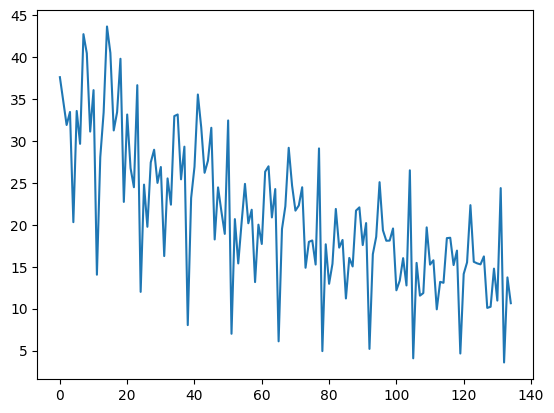

In [ ]:
plt.plot([i for i in range(len(loss_list))], [float(loss) for loss in loss_list])

In [ ]:
nn_five = NLP(784, [32, 5])
t_loss = []
t_loss_b = []

In [ ]:
for iter in range(5):
    total_train_loss = 0

    for start in range(int(len(fiv_tensor)//10)):
      # forward prop
        preds_batch = [nn_five(tensor) for tensor in fiv_tensor[start*10:10+(start*10)]]

        # softmaxing
        sft_preds_batch = []
        for preds in preds_batch:
            exp = [i.exp() for i in preds]
            sexp = sum(exp)
            sft_preds = [ex/sexp for ex in exp]
            sft_preds_batch.append(sft_preds)

        preds_vals = [sft_preds[lab] for sft_preds, lab in zip(sft_preds_batch, fiv_label[start*10:(start*10)+10])]
        loss = sum([p_val.log() * -1 for p_val in preds_vals])
        total_train_loss += loss.data

        # grad-decent
        for p in nn_five.parameters():
            p.grad = 0

        loss.backward()

        for p in nn_five.parameters():
            p.data = p.data - (0.05/(iter+1) * p.grad)


        # validation testing
        val_preds = [nn_five(test_tensor) for test_tensor in fiv_tensor_test]

        val_sft_preds = []
        for preds in val_preds:
            exp = [i.exp() for i in preds]
            sexp = sum(exp)
            sft_preds = [ex/sexp for ex in exp]
            val_sft_preds.append(sft_preds)

        val_preds_vals = [sft_preds[lab] for sft_preds, lab in zip(val_sft_preds, fiv_label_test)]
        val_loss = sum([p_val.log() * -1 for p_val in val_preds_vals])

        t_loss_b.append([loss.data, val_loss.data])
        print(f"iter: {iter}, batch:{start}, loss: {loss.data}, val loss: {val_loss.data}")

    print(f"### total trian loss: {total_train_loss} of iter: {iter}, validation loss: {val_loss.data} ###")
    t_loss.append([total_train_loss, val_loss.data])

iter: 0, batch:0, loss: 53.41802618734396, val loss: 117.84695538457608
iter: 0, batch:1, loss: 28.597018496967152, val loss: 102.65474478248069
iter: 0, batch:2, loss: 26.947858132954675, val loss: 98.1779918256562
iter: 0, batch:3, loss: 33.18361974258997, val loss: 54.632271490900166
iter: 0, batch:4, loss: 25.26598584935638, val loss: 41.727371391292834
iter: 0, batch:5, loss: 13.616743459910632, val loss: 39.73387574958238
iter: 0, batch:6, loss: 13.713041894498922, val loss: 36.91195666396991
iter: 0, batch:7, loss: 26.70633575914748, val loss: 38.63927423552567
iter: 0, batch:8, loss: 22.660931457258258, val loss: 44.32877696721765
iter: 0, batch:9, loss: 13.622253706633343, val loss: 24.05110460637288
iter: 0, batch:10, loss: 3.6097408663594193, val loss: 22.369104792517255
iter: 0, batch:11, loss: 4.992341905028181, val loss: 23.944718459937214
iter: 0, batch:12, loss: 9.546470218391594, val loss: 17.379099710903585
iter: 0, batch:13, loss: 8.014353536694596, val loss: 17.9217

In [13]:
plt.plot()

[[53.41802618734396, 117.84695538457608],
 [28.597018496967152, 102.65474478248069],
 [26.947858132954675, 98.1779918256562],
 [33.18361974258997, 54.632271490900166],
 [25.26598584935638, 41.727371391292834],
 [13.616743459910632, 39.73387574958238],
 [13.713041894498922, 36.91195666396991],
 [26.70633575914748, 38.63927423552567],
 [22.660931457258258, 44.32877696721765],
 [13.622253706633343, 24.05110460637288]]

In [15]:
total_train_loss

26.782494708839724

26.782494708839724

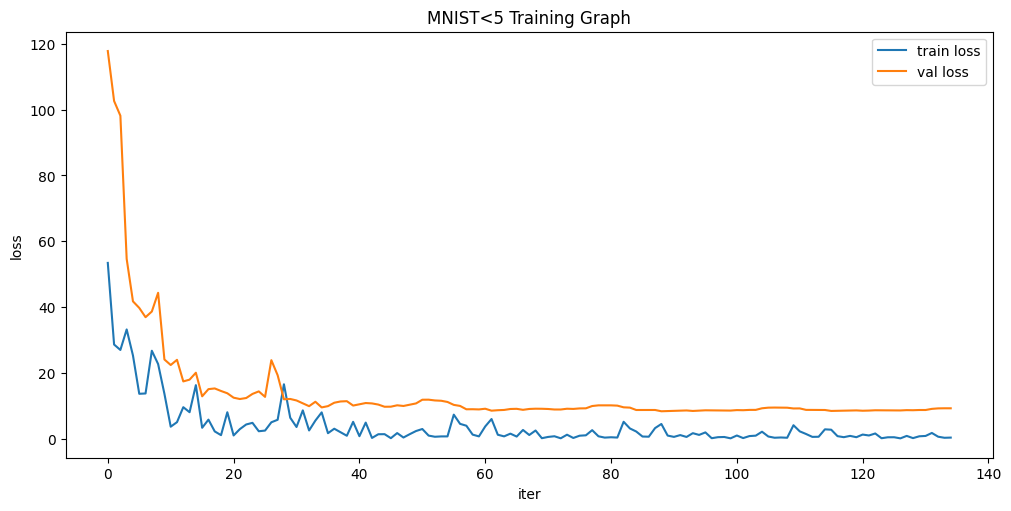

In [25]:
plt.figure(figsize=(10,5), layout='constrained')
plt.plot([i for i in range(len(t_loss_b))], [loss[0] for loss in t_loss_b], label="train loss")
plt.plot([i for i in range(len(t_loss_b))], [loss[1] for loss in t_loss_b], label="val loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("MNIST<5 Training Graph")
plt.legend();
